# Predicting Commodity Prices using Linear Regression in the Philippines
A **CS 180: Introduction to Artificial Intelligence** project that aims to develop a predictive **linear regression** model to accurately forecast commodity prices for future months and years using the **Philippine Food Prices Dataset**.

By Herminio Gregorio, Ali Jafri, and Ayen Manguan

## Preliminaries

First, import libraries and import our dataset. 

In [4012]:
# @title Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib as jb     # Save and load models

In [4013]:
# @title Load Dataset
data = pd.read_csv('wfp_food_prices_phl.csv')
data.head()

/var/folders/9l/h3zx8f2s6jn1tpcr1vcv95rc0000gp/T/ipykernel_10701/278703577.py:2: DtypeWarning: Columns (4,5,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('wfp_food_prices_phl.csv')


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,Maize flour (yellow),KG,actual,Retail,PHP,15.0,0.3717
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,Retail,PHP,20.0,0.4957
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,Wholesale,PHP,18.35,0.4548
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (regular, milled)",KG,actual,Wholesale,PHP,16.35,0.4052


Let's perform a bit of processing and take a quick look at our data.

In [4014]:
# @title Drop Missing Values
data = data.dropna()

In [4015]:
# @title Check shape and columns
data.shape
data.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')

There are 121,513 rows and 14 columns of data in our dataset!

# Preprocessing

First, we ensure that our dataset is ready for analysis!

In [4016]:
# @title Check information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121513 entries, 0 to 121512
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       121513 non-null  object
 1   admin1     121513 non-null  object
 2   admin2     121513 non-null  object
 3   market     121513 non-null  object
 4   latitude   121513 non-null  object
 5   longitude  121513 non-null  object
 6   category   121513 non-null  object
 7   commodity  121513 non-null  object
 8   unit       121513 non-null  object
 9   priceflag  121513 non-null  object
 10  pricetype  121513 non-null  object
 11  currency   121513 non-null  object
 12  price      121513 non-null  object
 13  usdprice   121513 non-null  object
dtypes: object(14)
memory usage: 13.0+ MB


In [4017]:
# @title Drop unnecessary columns
# `admin2` = Province; `market` = City; latitude and longitude = not needed;
# `currency` = all PHP; `usdprice` = not included in analysis; unit = not needed

data.drop(['admin2', 'market', 'latitude',
           'longitude', 'currency', 'usdprice', 'unit'], axis=1, inplace=True)

data.head()

,date,admin1,category,commodity,priceflag,pricetype,price
0,#date,#adm1+name,#item+type,#item+name,#item+price+flag,#item+price+type,#value
1,2000-01-15,National Capital region,cereals and tubers,Maize flour (yellow),actual,Retail,15.0
2,2000-01-15,National Capital region,cereals and tubers,"Rice (milled, superior)",actual,Retail,20.0
3,2000-01-15,National Capital region,cereals and tubers,"Rice (milled, superior)",actual,Wholesale,18.35
4,2000-01-15,National Capital region,cereals and tubers,"Rice (regular, milled)",actual,Wholesale,16.35


In [4018]:
# @title Remove first garbage row
data = data[1:]

In [4019]:
# @title Rename region

# Map region to an integer value
le = LabelEncoder()
data['region'] = le.fit_transform(data['admin1'])
data = data.drop(['admin1'], axis=1)

region_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(region_mapping)

data

{'Autonomous region in Muslim Mindanao': 0, 'Cordillera Administrative region': 1, 'National Capital region': 2, 'Region I': 3, 'Region II': 4, 'Region III': 5, 'Region IV-A': 6, 'Region IV-B': 7, 'Region IX': 8, 'Region V': 9, 'Region VI': 10, 'Region VII': 11, 'Region VIII': 12, 'Region X': 13, 'Region XI': 14, 'Region XII': 15, 'Region XIII': 16}


,date,category,commodity,priceflag,pricetype,price,region
1,2000-01-15,cereals and tubers,Maize flour (yellow),actual,Retail,15.0,2
2,2000-01-15,cereals and tubers,"Rice (milled, superior)",actual,Retail,20.0,2
3,2000-01-15,cereals and tubers,"Rice (milled, superior)",actual,Wholesale,18.35,2
4,2000-01-15,cereals and tubers,"Rice (regular, milled)",actual,Wholesale,16.35,2
5,2000-01-15,cereals and tubers,"Rice (milled, superior)",actual,Retail,19.0,5
...,...,...,...,...,...,...,...
121508,2021-02-15,vegetables and fruits,Ginger,aggregate,Retail,114.0,16
121509,2021-02-15,vegetables and fruits,Mangoes (carabao),aggregate,Retail,106.67,16
121510,2021-02-15,vegetables and fruits,Onions (red),aggregate,Retail,114.17,16
121511,2021-02-15,vegetables and fruits,Papaya,aggregate,Retail,45.0,16


For categories, we can drop them since commodities will be used as input; we can save the mapping for future purpose.

In [4020]:
# @title Drop category
category_commodity_mapping = data.groupby('category')['commodity'].apply(list).to_dict()

# Print the mapping
for category, commodities in category_commodity_mapping.items():
    print(f"{category}: {commodities}")

data = data.drop(['category'], axis=1)

cereals and tubers: ['Maize flour (yellow)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (regular, milled)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (regular, milled)', 'Maize flour (white)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (regular, milled)', 'Maize flour (white)', 'Maize flour (yellow)', 'Maize flour (yellow)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Maize flour (yellow)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (regular, milled)', 'Rice (milled, superior)', 'Rice (milled, superior)', 'Rice (regular, milled)', 'Rice (regular, milled)', 'Rice (milled

Price is listed as objects, which is problematic for processing. 

In [4021]:
# @title Convert datatypes
data['price'] = data['price'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121512 entries, 1 to 121512
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       121512 non-null  object 
 1   commodity  121512 non-null  object 
 2   priceflag  121512 non-null  object 
 3   pricetype  121512 non-null  object 
 4   price      121512 non-null  float64
 5   region     121512 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 5.6+ MB


In [4022]:
# @title Process date into own columns (year, month, day)
data['date'] = pd.to_datetime(data['date'])

# Distribute into own columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Drop raw date
data.drop('date', axis=1, inplace=True)

data.head()

,commodity,priceflag,pricetype,price,region,year,month,day
1,Maize flour (yellow),actual,Retail,15.00,2,2000,1,15
2,"Rice (milled, superior)",actual,Retail,20.00,2,2000,1,15
3,"Rice (milled, superior)",actual,Wholesale,18.35,2,2000,1,15
4,"Rice (regular, milled)",actual,Wholesale,16.35,2,2000,1,15
5,"Rice (milled, superior)",actual,Retail,19.00,5,2000,1,15


In [4023]:
unique_days = data['day'].unique()
print("Unique values in 'day' column:", unique_days)

Unique values in 'day' column: [15]


Since days are all the same, we can drop it.

In [4024]:
data = data.drop('day', axis=1)

Combine rows with price flags aggregate and actual.

In [4025]:
# # Group by the specified columns and calculate the mean of 'price' for 'actual' and 'aggregate' rows separately
# columns_to_check = ['price', 'category', 'commodity', 'unit', 'pricetype', 'region', 'year', 'month', 'day']

# # Calculate the mean of 'price' for each group of duplicate rows
# data['price'] = data.groupby(columns_to_check)['price'].transform('mean')

# # Drop the duplicate rows
# data = data.drop_duplicates()
# data = data.drop(columns=['priceflag'])

# data

Next, since linear regression cannot use categorical columns, we need to convert the m to numerical ones. We can use one-hot encoding to create binary columns for each feature.

In [4026]:
# Convert these columns into categorical
data = pd.get_dummies(data, columns=['priceflag', 'pricetype'])
column_order = data.columns.tolist()
print(column_order)
# data

['commodity', 'price', 'region', 'year', 'month', 'priceflag_actual', 'priceflag_aggregate', 'pricetype_Farm Gate', 'pricetype_Retail', 'pricetype_Wholesale']


In [4027]:
# Convert commodity variables to one-hot encoded variables
data_encoded = pd.get_dummies(data)
column_order = data_encoded.columns.tolist()
print(column_order)
data_encoded.info()

['price', 'region', 'year', 'month', 'priceflag_actual', 'priceflag_aggregate', 'pricetype_Farm Gate', 'pricetype_Retail', 'pricetype_Wholesale', 'commodity_Anchovies', 'commodity_Bananas (lakatan)', 'commodity_Bananas (latundan)', 'commodity_Bananas (saba)', 'commodity_Beans (green, fresh)', 'commodity_Beans (mung)', 'commodity_Beans (string)', 'commodity_Bitter melon', 'commodity_Bottle gourd', 'commodity_Cabbage', 'commodity_Cabbage (chinese)', 'commodity_Calamansi', 'commodity_Carrots', 'commodity_Chicken', 'commodity_Choko', 'commodity_Coconut', 'commodity_Crab', 'commodity_Eggplants', 'commodity_Eggs', 'commodity_Eggs (duck)', 'commodity_Fish (fresh)', 'commodity_Fish (frigate tuna)', 'commodity_Fish (mackerel, fresh)', 'commodity_Fish (milkfish)', 'commodity_Fish (redbelly yellowtail fusilier)', 'commodity_Fish (roundscad)', 'commodity_Fish (slipmouth)', 'commodity_Fish (threadfin bream)', 'commodity_Fish (tilapia)', 'commodity_Garlic', 'commodity_Garlic (large)', 'commodity_Gar

## Data Exploration

Let us explore our data and figure out what is the best approach for our model.

First, let's still use the `data` dataframe. We use data_encoded later on.

In [4028]:
# @title Check number of commodities and regions
num_unique_commodities = data['commodity'].nunique()
num_unique_regions = data['region'].nunique()
print(f"Commodities: {num_unique_commodities}; Regions: {num_unique_regions}")

Commodities: 73; Regions: 17


In [4029]:
# @title Inspect commodity types
unique_commodities = data['commodity'].unique()
print(unique_commodities)

['Maize flour (yellow)' 'Rice (milled, superior)' 'Rice (regular, milled)'
 'Maize flour (white)' 'Meat (pork)' 'Maize (yellow)' 'Maize (white)'
 'Rice (paddy)' 'Cabbage' 'Carrots' 'Garlic' 'Tomatoes' 'Potatoes (Irish)'
 'Sweet potatoes' 'Fish (fresh)' 'Meat (beef, chops with bones)'
 'Meat (chicken, whole)' 'Onions (red)' 'Onions (white)' 'Eggs'
 'Beans (mung)' 'Groundnuts (unshelled)' 'Rice (premium)' 'Rice (special)'
 'Rice (well milled)' 'Taro' 'Anchovies' 'Crab' 'Fish (frigate tuna)'
 'Fish (mackerel, fresh)' 'Fish (roundscad)' 'Fish (slipmouth)'
 'Fish (threadfin bream)' 'Meat (beef)' 'Meat (pork, with bones)'
 'Shrimp (endeavor)' 'Groundnuts (shelled)' 'Bananas (latundan)'
 'Bananas (saba)' 'Beans (green, fresh)' 'Beans (string)' 'Bitter melon'
 'Bottle gourd' 'Cabbage (chinese)' 'Calamansi' 'Choko' 'Coconut'
 'Eggplants' 'Ginger' 'Papaya' 'Squashes' 'Sweet Potato leaves'
 'Water spinach' 'Semolina (white)' 'Semolina (yellow)' 'Eggs (duck)'
 'Fish (milkfish)' 'Fish (redbelly yel

In [4030]:
tilapia_avg_price = data[data['commodity'] == 'Fish (tilapia)']['price'].mean()
milkfish_avg_price = data[data['commodity'] == 'Fish (milkfish)']['price'].mean()
'Rice (milled, superior)' 
print('Average price of Fish (Tilapia):', tilapia_avg_price)
print('Average price of Fish (Milkfish):', milkfish_avg_price)

Average price of Fish (Tilapia): 149.53441444372154
Average price of Fish (Milkfish): 190.06362053703157


While removing subcategories was considered in order to lessen the data, the price difference was too big and may affect results.

We will check if linear regression is the best model for our data.

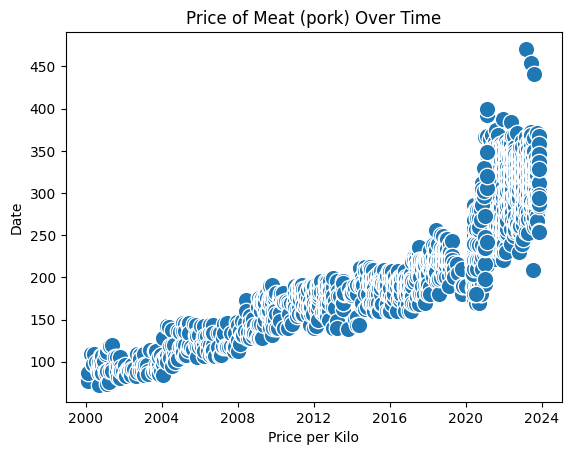

In [4031]:
# @title Pork Data

# Filter rows where commodity is pork
pork = data[(data['commodity'] == 'Meat (pork)')].copy()

# Add a 'day' column with the constant value 15
pork['day'] = 15

# Create the 'date' column
pork['date'] = pd.to_datetime(pork[['year', 'month', 'day']])

# Create the scatter plot
sns.scatterplot(x=pork['date'], y=pork['price'], s=140)

plt.xlabel('Price per Kilo')
plt.ylabel('Date')
plt.title('Price of Meat (pork) Over Time')
plt.show()

Let us perform regression on the dataset to test!

In [4032]:
pork.drop(['commodity', 'date'], axis=1, inplace=True)
pork

,price,region,year,month,priceflag_actual,priceflag_aggregate,pricetype_Farm Gate,pricetype_Retail,pricetype_Wholesale,day
33,77.00,5,2000,2,True,False,False,True,False,15
48,86.29,14,2000,2,True,False,False,True,False,15
80,108.71,2,2000,4,True,False,False,True,False,15
105,97.14,5,2000,5,True,False,False,True,False,15
114,97.64,11,2000,5,True,False,False,True,False,15
...,...,...,...,...,...,...,...,...,...,...
121169,306.33,4,2021,2,False,True,False,True,False,15
121198,392.00,5,2021,2,False,True,False,True,False,15
121224,400.00,6,2021,2,False,True,False,True,False,15
121366,242.33,11,2021,2,False,True,False,True,False,15


In [4033]:
# Split
X = pork.drop(['price'], axis=1).values
y = pork['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Train
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict
y_pred = regressor.predict(X_test)
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

mse = mean_squared_error(y_test, y_pred)

display(comparison_df)
print('MAE:', mean_absolute_error(y_test,y_pred))
print('MSE:', mse)
print("RMSE:",np.sqrt(mse))
print("r2:", r2_score(y_test,y_pred))

,Actual,Predicted
0,260.86,282.494522
1,340.00,293.167281
2,215.79,232.597299
3,95.11,90.361325
4,183.28,176.604377
...,...,...
589,310.00,284.514146
590,181.82,190.153813
591,336.25,294.999286
592,180.80,260.450594


MAE: 30.37989583689847
MSE: 1411.2707537183255
RMSE: 37.566883737120456
r2: 0.7587449139097658


Great, it seems that linear regression was effective for pork. Let's try it for the whole dataset.

# Model Training

In [4034]:
# Split
X = data_encoded.drop(['price'], axis=1).values
y = data_encoded['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Train
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict
y_pred = regressor.predict(X_test)
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

mse = mean_squared_error(y_test, y_pred)

display(comparison_df)
print('MAE:', mean_absolute_error(y_test,y_pred))
print('MSE:', mse)
print("RMSE:",np.sqrt(mse))
print("r2:", r2_score(y_test,y_pred))

,Actual,Predicted
0,83.18,79.561035
1,35.00,28.456177
2,29.89,30.495361
3,93.87,88.609497
4,48.92,61.791626
...,...,...
36449,200.00,134.057983
36450,195.00,186.217163
36451,226.25,270.438110
36452,208.75,142.536499


MAE: 23.859225253942682
MSE: 1590.309012089948
RMSE: 39.87867866529617
r2: 0.8715035177240367


In [4035]:
# Save the model
jb.dump(regressor, 'commodity-predict.pkl')
jb.dump(regressor, 'app/commodity-predict.pkl')

['app/commodity-predict.pkl']

# Sample prediction

In [4036]:
# Create a DataFrame for the new data
new_data = pd.DataFrame({
    'commodity': ['Rice (milled, superior)'],
    'year': [2030],
    'month': [12],
    'priceflag': ['actual'],
    'pricetype': ['Retail'],
    'region': [1]
})

# One-hot encode the categorical columns
new_data_encoded = pd.get_dummies(new_data, columns=['priceflag', 'pricetype', 'commodity'])

# Make sure new_data_encoded has the same columns as data_encoded
missing_cols = set(data_encoded.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0
new_data_encoded = new_data_encoded[data_encoded.columns]

# Drop the 'price' column if it exists
if 'price' in new_data_encoded.columns:
    new_data_encoded = new_data_encoded.drop(['price'], axis=1)
new_X = new_data_encoded.values

# Use the trained model to make predictions
new_y_pred = regressor.predict(new_X)

# new_y_pred now contains the predicted price for your new data
print("The predicted price is:", new_y_pred[0])

The predicted price is: 118.005859375
